# Transfer Learning using Resnet50 with a balanced dataset

### Reference:
**Training Residual Neural Network with your own dataset**:[link](https://www.youtube.com/watch?v=1Gbcp66yYX4&feature=youtu.be)

**confusion matrix**:[link](https://zhuanlan.zhihu.com/p/73558315)

In [2]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

**input data transform and preprocessing**

Here a balanced dataset is used. Can change dataset to test other possible results.

In [5]:
import os
import torch
from torchvision import datasets, transforms
import torchvision.models as models
img_height,img_width=(224,224)
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join('./coverimage', x),data_transforms[x]) for x in ['train', 'val', 'test']}

batch_size = 32

train_data_dir = r"./coverimage/train"
valid_data_dir = r"./coverimage/val"
test_data_dir = r"./coverimage/test"

In [6]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  validation_split=0.4)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                   target_size=(img_height,img_width),
                                                   batch_size=batch_size,
                                                   class_mode="categorical",
                                                   subset="training")#set as training data

valid_generator=train_datagen.flow_from_directory(valid_data_dir,
                                                 target_size=(img_height,img_width),
                                                 batch_size=batch_size,
                                                  class_mode="categorical",
                                                  subset="validation") #set as validation data

Found 3016 images belonging to 7 classes.
Found 448 images belonging to 7 classes.


In [7]:
test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_height,img_width),
                                                  batch_size=1,
                                                  class_mode="categorical",
                                                  subset="validation")

Found 557 images belonging to 7 classes.


In [5]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [6]:
train_generator.num_classes

7

In [7]:
base_model = ResNet50(include_top=False,weights="imagenet")
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation="relu")(x)
predictions = Dense (train_generator.num_classes,activation="softmax")(x)
model = Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

model.fit(train_generator,
         epochs = 10)

Epoch 1/10
9/9 [==============================] - 38s 4s/step - loss: 5.2283 - accuracy: 0.1279
Epoch 2/10
9/9 [==============================] - 37s 4s/step - loss: 2.7132 - accuracy: 0.2829
Epoch 3/10
9/9 [==============================] - 56s 6s/step - loss: 1.9796 - accuracy: 0.3062
Epoch 4/10
9/9 [==============================] - 34s 4s/step - loss: 1.3922 - accuracy: 0.4884
Epoch 5/10
9/9 [==============================] - 60s 7s/step - loss: 1.1315 - accuracy: 0.5930
Epoch 6/10
9/9 [==============================] - 35s 4s/step - loss: 1.0686 - accuracy: 0.6240
Epoch 7/10
9/9 [==============================] - 38s 4s/step - loss: 0.8929 - accuracy: 0.6938
Epoch 8/10
9/9 [==============================] - 54s 6s/step - loss: 0.6274 - accuracy: 0.8527
Epoch 9/10
9/9 [==============================] - 38s 4s/step - loss: 0.5378 - accuracy: 0.8682
Epoch 10/10
9/9 [==============================] - 57s 6s/step - loss: 0.5023 - accuracy: 0.8605


save model

In [121]:
model.save("./coverimage/Saved_Model/ResNet50_covers2.h5")

test accuracy:

In [122]:
test_loss,test_acc = model.evaluate(test_generator,verbose=2)
print("\nTest accuracy:",test_acc)

557/557 - 104s - loss: 2.4416 - accuracy: 0.2513

Test accuracy: 0.25134649872779846


Confusion Matrix:

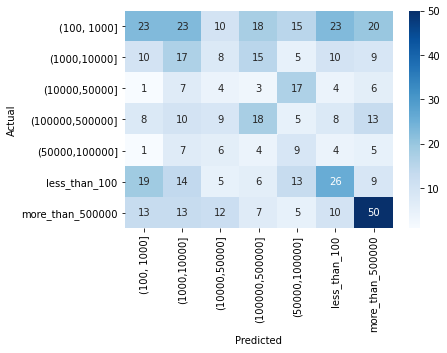

test accuracy: 26.391382405745063


In [93]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model("./coverimage/Saved_Model/ResNet50_covers2.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
# nb_samples = 2
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
#     print(X_test)
#     print(Y_test)
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
    
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=["predicted_class","actual_class"])
confusion_matrix = pd.crosstab(out_df["actual_class"],out_df["predicted_class"],rownames=["Actual"],colnames=["Predicted"])

sn.heatmap(confusion_matrix,cmap="Blues",annot=True,fmt="d")
plt.show()
print("test accuracy: {}".format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))